In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/end2end pipeline ieco/'

/content/drive/MyDrive/end2end pipeline ieco


In [ ]:
import os
import json
import cv2
from tqdm import tqdm
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

DATA_DIR = '/content/drive/MyDrive/end2end pipeline ieco/roof_dataset/'
RAW_DATA_DIR = os.path.join(DATA_DIR, 'Valid_Projects_Batch_1/')
YOLO_DATA_DIR = os.path.join(DATA_DIR, 'yolo_data/')
IMAGE_SIZE = (512, 512)

def process_data(sample_folders: list, destination: str):
    image_folder = os.path.join(destination, 'images/')
    label_folder = os.path.join(destination, 'labels/')
    os.makedirs(image_folder, exist_ok=True)
    os.makedirs(label_folder, exist_ok=True)

    for sample in tqdm(sample_folders, desc='processing roof samples..'):
        sample_folder = os.path.join(RAW_DATA_DIR, sample)
        image_path = os.path.join(sample_folder, 'google.jpg')
        planes_path = os.path.join(sample_folder, 'planes.json')
        info_path = os.path.join(sample_folder, 'info.json')

        label_path = os.path.join(label_folder, sample + '.txt')
        new_image_path = os.path.join(image_folder, sample + '.jpg')

        with open(info_path, 'r') as f:
            info = json.load(f)

        with open(planes_path, 'r') as f:
            planes = json.load(f)

        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        cv2.imwrite(new_image_path, image)

        scale = IMAGE_SIZE[0] / info['size']
        shift = IMAGE_SIZE[0] // 2

        # Combine all polygons into one outer perimeter
        polygons = []
        for polygon in planes:
            points = [(scale * point['x'] + shift, scale * -point['y'] + shift) for point in polygon['perimeter']]
            poly = Polygon(points)
            if poly.is_valid:
                polygons.append(poly)
            else:
                print(f'Invalid polygon: {polygon}')

        if len(polygons) > 0:
            combined_polygon = unary_union(polygons)

            # Handle case where the result is a MultiPolygon
            if isinstance(combined_polygon, MultiPolygon):
                combined_polygon = combined_polygon.convex_hull

            # Write the outer perimeter as a single object
            with open(label_path, 'w') as txt_file:
                row = '0 '  # Assuming '0' is the class label for the roof
                for x, y in combined_polygon.exterior.coords:
                    norm_x, norm_y = round(x / IMAGE_SIZE[0], 3), round(y / IMAGE_SIZE[1], 3)
                    row += f'{norm_x} {norm_y} '
                txt_file.write(row + '\n')

        else:
          print(f'No valid polygons found in {sample}')

In [ ]:
n_train = int(len(os.listdir(RAW_DATA_DIR)) * 0.8)
train_files = sorted(os.listdir(RAW_DATA_DIR))[:n_train]
test_files = sorted(os.listdir(RAW_DATA_DIR))[n_train:]
print('[TRAINING]')
process_data(train_files, os.path.join(YOLO_DATA_DIR, 'train'))
print('[VALIDATION]')
process_data(test_files, os.path.join(YOLO_DATA_DIR, 'val'))

processing roof samples..:  25%|██▌       | 22/88 [00:00<00:02, 27.14it/s]

Invalid polygon: {'azimuth': 180, 'height': 6.3, 'perimeter': [{'x': -40.45210040983608, 'y': 8.360655737709099}, {'x': -40.45210040983607, 'y': 8.360655737709099}, {'x': -41.02243731523278, 'y': 7.753319195588318}, {'x': -30.411859001956767, 'y': 19.052240730754264}, {'x': 26.02330942622952, 'y': -36.229508196737584}, {'x': 25.316416309860575, 'y': -36.97669469446522}, {'x': 14.664062453517658, 'y': -48.236239859313415}, {'x': -40.45210040983608, 'y': 8.360655737709099}], 'tilt': 0}
Invalid polygon: {'azimuth': 312.86200414098926, 'height': 6.3, 'perimeter': [{'x': 36.566950863061706, 'y': -24.86809872205024}, {'x': 26.02330942622952, 'y': -36.229508196737584}, {'x': -30.411859001956767, 'y': 19.052240730754264}, {'x': -29.12283431767868, 'y': 20.38628180092109}, {'x': -18.352360570429592, 'y': 31.532890938224604}, {'x': -18.352360570428893, 'y': 31.53289093822436}, {'x': -18.93938046712072, 'y': 31.34619823400898}, {'x': 36.566950863061706, 'y': -24.86809872205024}], 'tilt': 0}
No va

processing roof samples..:  70%|███████   | 62/88 [00:02<00:01, 25.63it/s]

No valid polygons found in 888bb53c180dc6a9a909dc2b84bb14b298c3e114


processing roof samples..:  84%|████████▍ | 74/88 [00:02<00:00, 26.24it/s]

Invalid polygon: {'azimuth': 73.86135778128585, 'height': 4, 'perimeter': [{'x': -41.398128513271324, 'y': 24.410597953040288, 'z': 0}, {'x': -44.059378589446375, 'y': 33.60743067846106, 'z': 0}, {'x': 5.883455772540003, 'y': 56.89168017640365, 'z': 0}, {'x': 10.196027882875542, 'y': 48.349468882051625, 'z': 0}, {'x': 10.196027882875542, 'y': 48.44987433553693, 'z': 0}, {'x': -41.398128513271324, 'y': 24.410597953040288, 'z': 0}], 'tilt': 0}


processing roof samples..:  43%|████▎     | 10/23 [00:00<00:00, 28.15it/s]

Invalid polygon: {'azimuth': 297.89253196540614, 'height': 12.98, 'perimeter': [{'x': -4.9881094364111584, 'y': 57.695058255195804}, {'x': -5.103488625847622, 'y': 57.576442522054116}, {'x': 25.082241772756248, 'y': 42.48060931209839}, {'x': -18.123257713862184, 'y': -39.14610512900282}, {'x': -48.324817462979496, 'y': -24.081965966060338}, {'x': -4.9881094364111584, 'y': 57.695058255195804}], 'tilt': 7.8}


processing roof samples..:  70%|██████▉   | 16/23 [00:00<00:00, 27.85it/s]

No valid polygons found in e1a3f552a66b60d555306d8fc3f1a0a42eb8b50d


processing roof samples..: 100%|██████████| 23/23 [00:00<00:00, 26.83it/s]


In [ ]:
import yaml

# YOLO dataset configuration
data = {
    'train': 'train/images',  # Path to training images
    'val': 'val/images',      # Path to validation images
    'nc': 1,  # Number of classes
    'names': {
        0: 'roof',
    }
}

DATA_YAML_PATH = os.path.join(YOLO_DATA_DIR, 'roof_data.yaml')
with open(DATA_YAML_PATH, 'w') as yml_file:
    yaml.dump(data, yml_file, default_flow_style=False)


In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.2 MB/s eta 0:00:00


In [ ]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=os.path.join(YOLO_DATA_DIR, 'train/images/'),
    annotations_directory_path=os.path.join(YOLO_DATA_DIR, 'train/labels/'),
    data_yaml_path=os.path.join(YOLO_DATA_DIR, 'roof_data.yaml'),
)

len(dataset)

88

In [ ]:
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (10, 10)

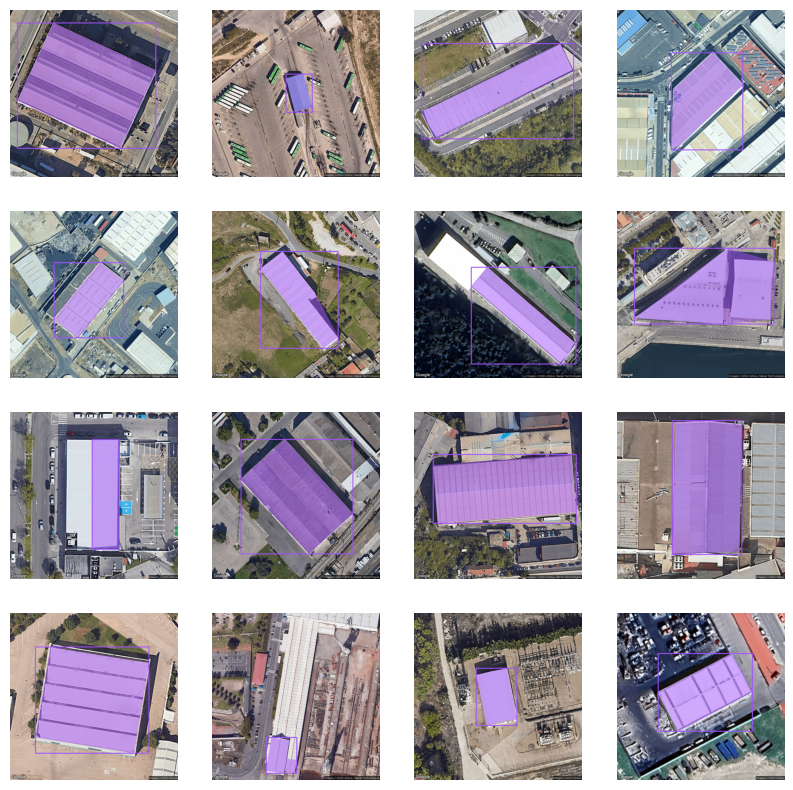

In [ ]:
from pathlib import Path

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for i, (_, image, annotation) in enumerate(dataset):
    if i == SAMPLE_SIZE:
        break
    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(
        scene=annotated_image, detections=annotation)
    annotated_image = box_annotator.annotate(
        scene=annotated_image, detections=annotation)
    images.append(annotated_image)

sv.plot_images_grid(
    images=images,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 22.2 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n-seg.pt")
results = model.train(data=DATA_YAML_PATH, epochs=50)

100%|██████████| 5.90M/5.90M [00:00<00:00, 101MB/s]


Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/drive/MyDrive/end2end pipeline ieco/roof_dataset/yolo_data/roof_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.7MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/end2end pipeline ieco/roof_dataset/yolo_data/train/labels... 86 images, 2 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<00:00, 110.56it/s]


train: New cache created: /content/drive/MyDrive/end2end pipeline ieco/roof_dataset/yolo_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/end2end pipeline ieco/roof_dataset/yolo_data/val/labels... 22 images, 1 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 48.53it/s]


val: New cache created: /content/drive/MyDrive/end2end pipeline ieco/roof_dataset/yolo_data/val/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.12G      1.556      5.776      3.205      1.934         16        640: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         23         22    0.00319          1      0.218     0.0988    0.00261      0.818      0.152     0.0582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50         3G      1.153      4.482      2.933      1.625         22        640: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         23         22    0.00319          1      0.525      0.255    0.00304      0.955       0.42       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.99G      0.729      1.672      2.453      1.203         26        640: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         22    0.00319          1      0.642      0.322    0.00246      0.773      0.552      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.98G     0.7962       1.69      2.225      1.272         23        640: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         23         22    0.00319          1      0.601      0.338    0.00261      0.818      0.363      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50         3G     0.7136      1.354      1.965      1.176         24        640: 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         23         22    0.00319          1      0.489      0.316    0.00261      0.818      0.352      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.98G     0.8046      1.406      1.774       1.28         18        640: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         23         22    0.00304      0.955      0.674      0.464    0.00261      0.818       0.52      0.186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.99G     0.8528       1.54      1.687      1.325         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         22       0.57      0.136      0.362      0.146       0.64      0.164      0.185     0.0826



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.04G     0.8027      1.479      1.668      1.243         15        640: 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         23         22          1       0.12      0.426      0.174      0.619     0.0779      0.195      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.03G     0.8537      1.454      1.648       1.23         13        640: 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         23         22      0.844      0.491      0.642      0.289      0.494      0.267      0.322      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50         3G     0.7944      1.356      1.472      1.182         24        640: 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         23         22      0.715      0.228      0.449      0.211       0.83      0.222       0.31      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50         3G     0.7952      1.294      1.507      1.257         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         23         22          1      0.387      0.654      0.314      0.735      0.273      0.306      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.98G     0.8493      1.221      1.498       1.29         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         23         22      0.646      0.682      0.687      0.364      0.345      0.364      0.289     0.0913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.06G     0.7834      1.218      1.402      1.213         15        640: 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         23         22      0.733        0.5      0.629      0.351      0.733        0.5      0.558      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.98G     0.7925      1.281      1.366       1.27         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         23         22      0.681      0.591      0.621      0.305      0.476      0.372      0.364      0.129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.97G     0.8229      1.285      1.411      1.222         21        640: 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         23         22       0.55      0.636      0.535      0.246      0.418      0.273      0.205     0.0687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50         3G     0.8064      1.226        1.3      1.214         22        640: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         23         22      0.647        0.5      0.581       0.25      0.446      0.273      0.143     0.0465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50         3G     0.7559      1.164      1.313      1.234         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         23         22      0.715      0.685      0.734      0.416      0.732      0.498      0.536      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.98G     0.7305       1.03      1.258      1.176         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         23         22      0.433      0.773      0.492      0.239      0.527        0.5      0.397      0.181



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50         3G      0.787      1.289      1.252      1.191         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         23         22       0.31       0.49      0.265     0.0937      0.533      0.182      0.174       0.05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50         3G      0.838       1.38      1.329      1.297         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         23         22      0.559        0.5      0.456      0.155      0.859     0.0455     0.0556     0.0257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50         3G     0.7852      1.212      1.231      1.207         22        640: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         23         22      0.417      0.455      0.423       0.15      0.558      0.136      0.176     0.0535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.01G     0.6772      1.163      1.097      1.106         20        640: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         23         22      0.426      0.318       0.26      0.106      0.361      0.273      0.168     0.0371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.99G     0.7686      1.222      1.134      1.186         24        640: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         23         22      0.472      0.182      0.194      0.071      0.531      0.136       0.11     0.0176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50         3G     0.7292      1.175      1.095      1.188         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         23         22      0.315      0.136      0.168     0.0619     0.0762     0.0455      0.013    0.00369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.98G     0.6699     0.8915     0.9776      1.142         19        640: 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         23         22      0.276      0.225      0.157     0.0592       0.91     0.0455     0.0684     0.0103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.98G      0.761      1.077      1.098      1.212         27        640: 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         23         22       0.31      0.273      0.217     0.0852      0.155      0.136     0.0797     0.0251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.97G     0.6386      0.964     0.9648      1.089         22        640: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         23         22      0.432      0.364       0.37      0.148      0.273      0.227      0.125      0.041



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.98G     0.7032      1.091      1.067      1.173         25        640: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         23         22      0.859      0.682      0.768      0.483        0.8      0.636      0.612      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50         3G     0.6964      1.085      1.008      1.152         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         23         22      0.766      0.773      0.763      0.461      0.867      0.636      0.738      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50         3G     0.6139     0.9948     0.9798      1.107         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         23         22      0.871      0.682      0.778      0.455      0.785      0.591      0.617      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.99G     0.6331      1.006     0.9781      1.123         24        640: 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         23         22      0.816      0.682      0.758       0.43      0.757      0.636      0.636      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.96G     0.6206      1.005     0.9297      1.134         20        640: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         23         22      0.873      0.682      0.823       0.49      0.756      0.591      0.615      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.99G     0.6533      1.019      0.929        1.1         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         23         22      0.936      0.682      0.757      0.473      0.936      0.682      0.716       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.02G     0.5964      0.977     0.8911      1.067         25        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         23         22      0.947      0.816      0.817      0.546      0.874      0.727      0.704      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.98G     0.5657     0.9106     0.7959      1.102         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         23         22      0.995      0.864       0.91      0.577      0.836      0.727      0.706      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.02G     0.6699     0.9546     0.9067      1.144         19        640: 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         23         22      0.937      0.818      0.888      0.649      0.832      0.727      0.762      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50         3G     0.5904      0.853      0.882      1.094         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         23         22      0.939      0.818       0.89      0.656      0.834      0.727      0.752       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.02G     0.6322     0.9745     0.8913       1.12         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         23         22       0.99      0.864      0.932      0.632      0.884      0.773      0.733      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50         3G     0.5403     0.7994     0.7742      1.057         22        640: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         23         22      0.989      0.864      0.932      0.626      0.884      0.773      0.739      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50         3G     0.6043     0.9105     0.8625      1.067         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         23         22      0.899      0.864      0.928      0.634      0.803      0.773      0.746       0.56


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.95G     0.6799     0.7987      1.445      1.397          8        640: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         23         22      0.997      0.818      0.907      0.622      0.886      0.727      0.762      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.95G     0.6486     0.7979        1.3      1.317          7        640: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         23         22      0.904      0.861      0.926      0.613      0.809       0.77      0.727      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.95G     0.5474     0.7084      1.097      1.179          8        640: 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         23         22      0.948      0.836       0.95      0.597      0.797      0.716      0.705      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.95G     0.5659     0.6991      1.059       1.23          8        640: 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         23         22      0.865      0.874      0.964       0.58      0.837        0.7      0.687      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.95G     0.4934     0.6368      1.007       1.14          8        640: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         23         22      0.987      0.864      0.984      0.606       0.83      0.727      0.713      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.03G     0.5291     0.6611      1.053      1.182          8        640: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         23         22          1      0.908      0.963      0.638       0.85      0.773      0.759      0.611



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.95G     0.4624     0.6109     0.9495      1.072          8        640: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         23         22          1      0.909      0.957      0.673      0.899      0.818      0.827      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.01G     0.5485     0.6658     0.9876      1.192          8        640: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         23         22      0.947      0.909      0.969      0.683       0.81      0.864      0.825      0.669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.95G     0.5063     0.6652      1.001      1.194          8        640: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         23         22      0.954      0.947      0.971      0.676      0.863      0.857      0.815      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.95G     0.5419     0.6005     0.9329       1.11          8        640: 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         23         22      0.954       0.95      0.965      0.687      0.863      0.861      0.817      0.671



50 epochs completed in 0.060 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


                   all         23         22      0.954       0.95      0.965      0.682      0.863      0.861      0.817      0.671
Speed: 0.2ms preprocess, 3.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


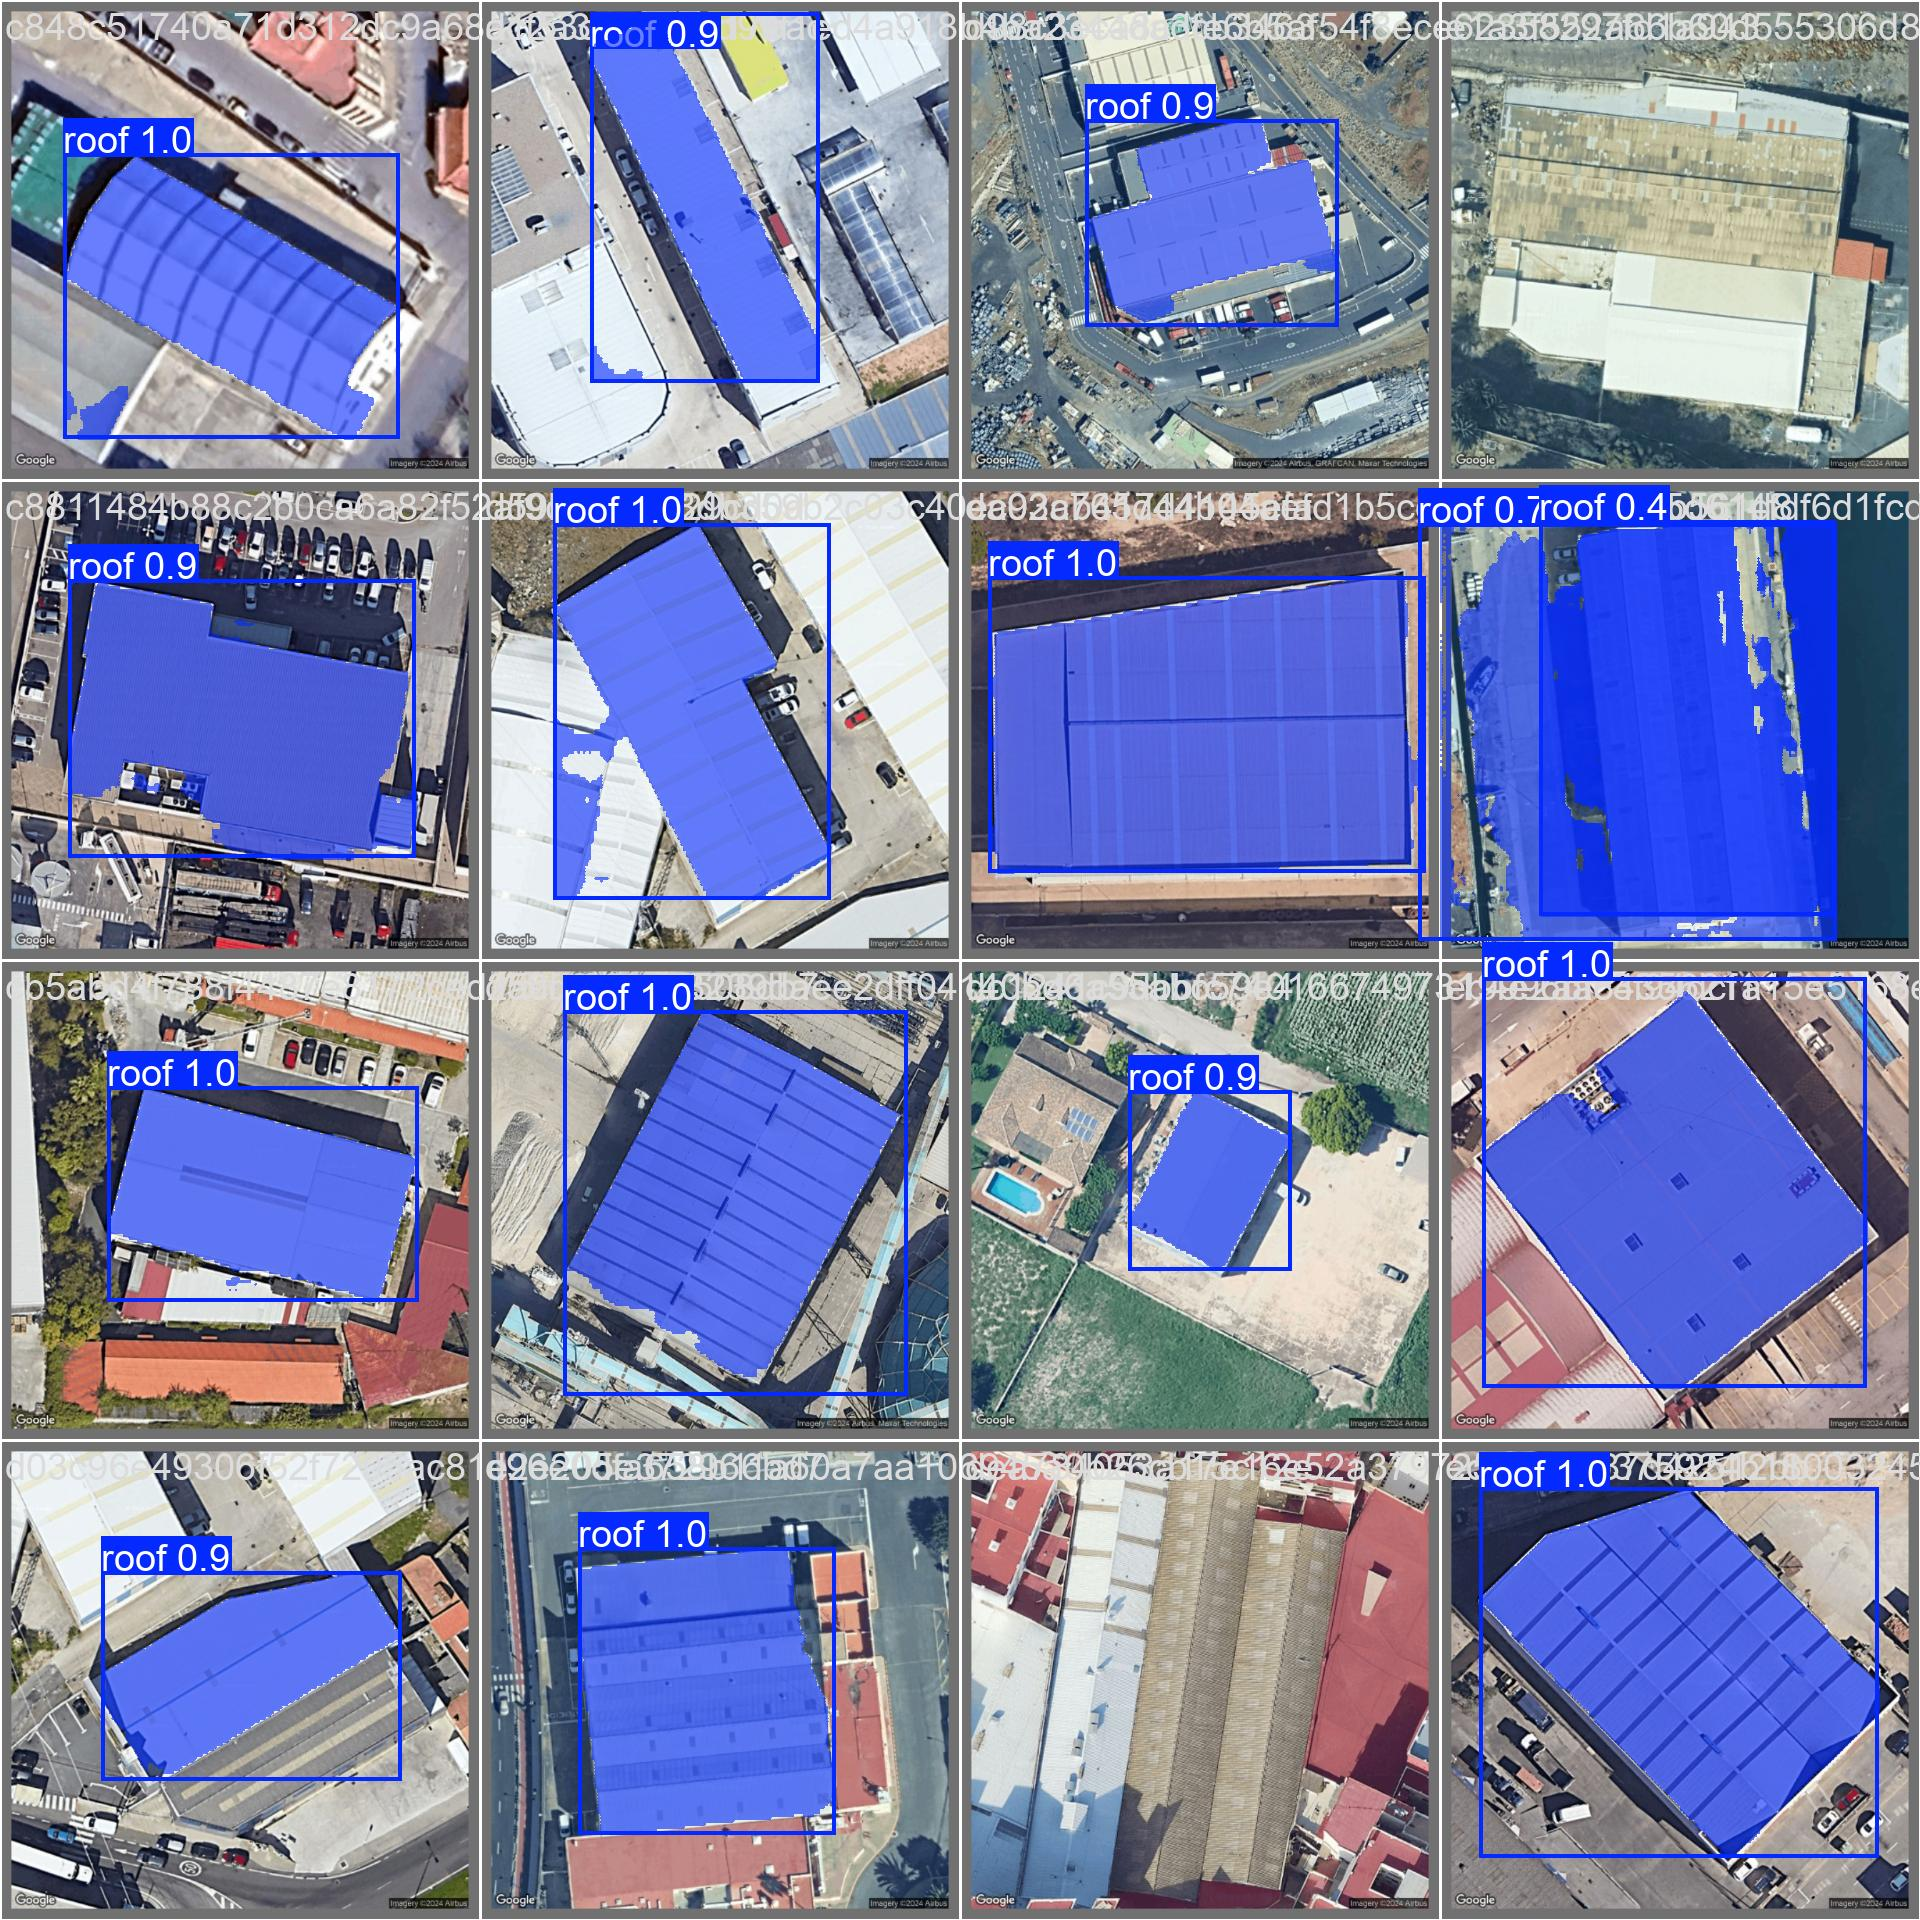

In [ ]:
from IPython.display import Image

Image('runs/segment/train/val_batch0_pred.jpg')

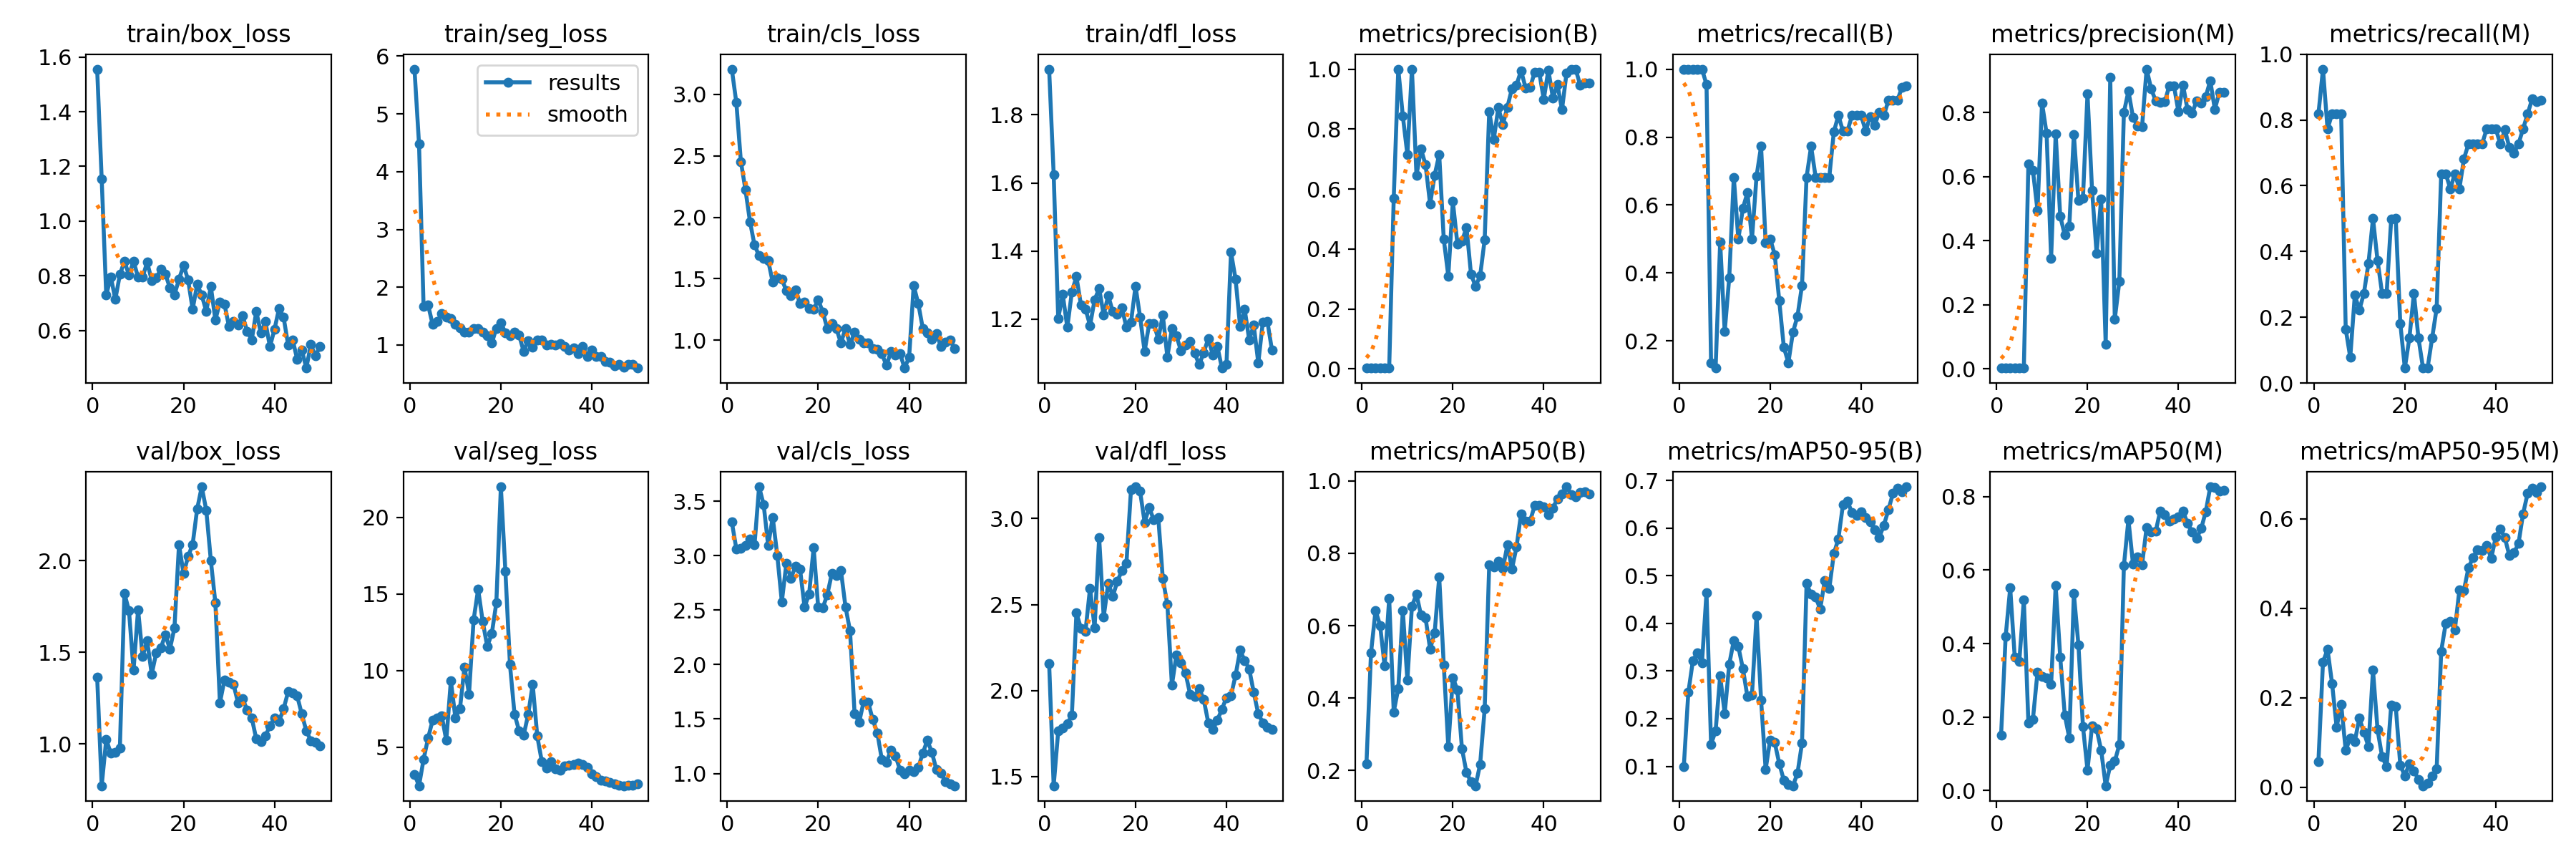

In [ ]:
Image('runs/segment/train/results.png')


image 1/1 /content/drive/MyDrive/end2end pipeline ieco/roof_dataset/yolo_data/val/images/da93c765d44b04aefd1b5cd6c67568512eb561d8.jpg: 640x640 1 roof, 16.9ms
Speed: 2.7ms preprocess, 16.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


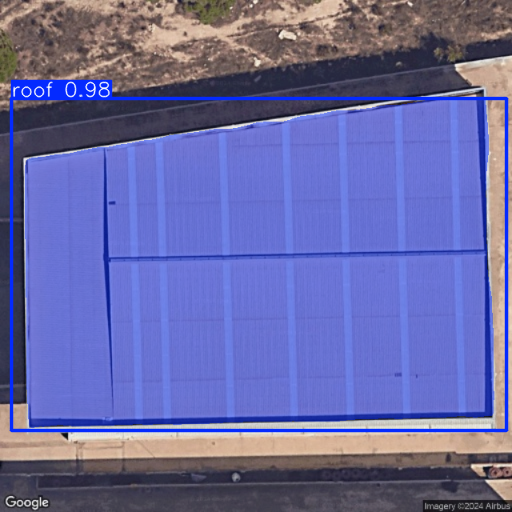

In [ ]:
result = model('roof_dataset/yolo_data/val/images/da93c765d44b04aefd1b5cd6c67568512eb561d8.jpg')[0]
result.show()

In [ ]:
import numpy as np

with open(os.path.join(RAW_DATA_DIR, 'da93c765d44b04aefd1b5cd6c67568512eb561d8/dsm.json')) as f:
  point_cloud = np.array(json.load(f))
  print(point_cloud.shape)

with open(os.path.join(RAW_DATA_DIR, 'da93c765d44b04aefd1b5cd6c67568512eb561d8/info.json')) as f:
  info = json.load(f)
  print(info['size'])

(9460, 3)
72.8258100608276
